# Scripting a renderer

## Overview

Mitsuba provides a flexible API that allows developing custom rendering pipelines that largely bypass the high-level interfaces and machinery used in the previous tutorials. This enables the use of the Mitsuba to rapidly prototype new and unconventional applications, while still leveraging the high performance JIT compiler and integrated ray acceleration data structures.

In this example, we are going to implement an ambient occlusion renderer that mostly avoids using built-in plugins (e.g., does not use existing sensor and film interfaces). This tutorial can serve as a starting point for more advanced custom rendering methods.

<div class="admonition important alert alert-block alert-success">

🚀 **You will learn how to:**
    
<ul>
  <li>Use Mitsuba as a framework to write your own rendering pipeline</li>
  <li>Spawn a wavefront of rays in Python</li>
  <li>Generate random numbers with the <tt>PCG32</tt> class</li>  
  <li>Work with the <tt>Loop</tt> construct</li>
</ul>
    
</div>


## Setup

Like in the previous tutorials, we start by importing the Mitsuba and DrJit and loading a scene.

In [1]:
import mitsuba as mi
import drjit as dr

mi.set_variant('llvm_ad_rgb')

scene = mi.load_file('../scenes/cbox.xml')

While it is possible to use Mitsuba in `scalar` mode, it is highly recommended to stick to the JIT-compiled variants of the system (i.e., `llvm` or `cuda`) for performance critical applications implemented using the Python API. In `scalar` mode, we would pay the overhead of the Python binding layer for every function call on every individual sample/ray in our simulation. Using a JIT-compiled variant largely eliminates any Python related overheads and allows the system to efficiently use the available hardware.

## Spawning rays

In this tutorial, we replace large parts of Mitsuba's high-level rendering pipeline by relatively low level Python code to demonstrate the system's flexibility. We start by implementing a camera model and corresponding ray generation routine. In this experiment, we will implement a simple orthographic camera, given the following parameters:

In [2]:
# Camera origin in world space
cam_origin = mi.Point3f(0, 1, 3)

# Camera view direction in world space
cam_dir = dr.normalize(mi.Vector3f(0, -0.5, -1))

# Camera width and height in world space
cam_width  = 2.0
cam_height = 2.0

# Image pixel resolution
image_res = (256, 256)

We will now spawn a whole wavefront of camera rays that can be processed all at once in a vectorized way. We first generate ray origins in the camera's local coordinate frame using `dr.meshgrid` and `dr.linspace`. These functions behave similarly to their equivalents in NumPy. We construct a 2D grid of ray origins based on the camera's physical dimensions (`cam_height`, `cam_width`) and image resolution (`image_res`).

The ray origins in local coordinates then need to be transformed into world space to account for the camera's viewing direction and 3D position. We first construct a coordinate frame ([<code>mi.Frame3f</code>][1]) that is oriented in the camera's viewing direction. Using its [<code>to_world()</code>][2] method we rotate our ray origins into world space and finally add the camera's world space position.

[1]: https://mitsuba.readthedocs.io/en/latest/src/api_reference.html#mitsuba.Frame3f
[2]: https://mitsuba.readthedocs.io/en/latest/src/api_reference.html#mitsuba.Frame3f.to_world

In [3]:
# Construct a grid of 2D coordinates
x, y = dr.meshgrid(
    dr.linspace(mi.Float, -cam_width  / 2,   cam_width / 2, image_res[0]),
    dr.linspace(mi.Float, -cam_height / 2,  cam_height / 2, image_res[1])
)

# Ray origin in local coordinates
ray_origin_local = mi.Vector3f(x, y, 0)

# Ray origin in world coordinates
ray_origin = mi.Frame3f(cam_dir).to_world(ray_origin_local) + cam_origin

We can now assemble a wavefront of world space rays that will later be traced in our rendering algorithm.

In [4]:
ray = mi.Ray3f(o=ray_origin, d=cam_dir)

We then intersect those primary rays against the scene geometry to compute the corresponding surface interactions (of type [<code>SurfaceInteraction3f</code>][1]).

[1]: https://mitsuba.readthedocs.io/en/latest/src/api_reference.html#mitsuba.SurfaceInteraction3f

In [5]:
si = scene.ray_intersect(ray)

## Ambient occlusion

Ambient occlusion is a rendering technique that calculates the average local occlusion of surfaces. For a point on the surface, we trace a set of rays (`ambient_ray_count`) in random directions on the hemisphere and compute the fraction of rays that intersect another surface within a specific maximum range (`ambient_range`).

In [6]:
ambient_range = 0.75
ambient_ray_count = 256

To sample random directions on the hemisphere, we need to instantiate a random number generator. Instead of using an existing `Sampler` plugin, we directly use the [<code>PCG32</code>][1] class that is provided by DrJit. This random number generator is initialized using the size of our wavefront of rays. We can then call [<code>rng.next_float32()</code>][2] to sample uniformly distributed random numbers in $[0, 1)$.

[1]: https://mitsuba.readthedocs.io/en/latest/src/api_reference.html#mitsuba.PCG32
[2]: https://mitsuba.readthedocs.io/en/latest/src/api_reference.html#mitsuba.Sampler.next_float32

In [7]:
# Initialize the random number generator
rng = mi.PCG32(size=dr.prod(image_res))

In the following code, we use the `dr.syntax` decorator that allows JIT variables to be traced when used in Python control flow statements (see the [Dr.Jit documentation][1] for more details).

In particular, this allows us to use a standard `while` loop over ambient occlusion samples to perform the following: 

1. We first draw two random numbers from the `PCG32` instance. 
2. We use those random numbers to sample directions on the hemisphere (in local coordinates, where the z-axis is aligned to the surface normal). 
3. Those directions then need to be transformed to world space using the local coordinate frame of the surface. The surface interaction record `si` ([<code>SurfaceInteraction3f</code>][2]) stores this local coordinate frame ([<code>Frame3f</code>][3]) which can be used for this transformation.
4. We then spawn probe rays into the sampled world space direction using `si.spawn_ray(...)`. This method implements some logic to prevent self-intersection with the surface at `si`. It should always be preferred over constructing the ray manually in such situations.
5. We set the ambient occlusion ray's `maxt` value to only find occluders in the provided maximum range.
6. We accumulate a value of `1.0` if the ray did not intersect any scene geometry.
7. Finally we increment the loop iteration counter and move on to the next iteration.

After the loop, we divide the result by the number of ambient occlusion samples to get the average occlusion.

[1]: https://drjit.readthedocs.io/en/latest/cflow.html
[2]: https://mitsuba.readthedocs.io/en/latest/src/api_reference.html#mitsuba.SurfaceInteraction3f
[3]: https://mitsuba.readthedocs.io/en/latest/src/api_reference.html#mitsuba.Frame3f

In [8]:
# Accumulated result
result = mi.Float(0)

@dr.syntax
def my_loop(result, si, rng, ambient_ray_count):
    # Loop iteration counter
    i = mi.UInt32(0)
    
    while (si.is_valid() & (i < ambient_ray_count)):
        # 1. Draw some random numbers
        sample_1, sample_2 = rng.next_float32(), rng.next_float32()

        # 2. Compute directions on the hemisphere using the random numbers
        wo_local = mi.warp.square_to_uniform_hemisphere([sample_1, sample_2])

        # Alternatively, we could also sample a cosine-weighted hemisphere
        # wo_local = mi.warp.square_to_cosine_hemisphere([sample_1, sample_2])

        # 3. Transform the sampled directions to world space
        wo_world = si.sh_frame.to_world(wo_local)

        # 4. Spawn a new ray starting at the surface interactions
        ray_2 = si.spawn_ray(wo_world)

        # 5. Set a maximum intersection distance to only account for the close-by geometry
        ray_2.maxt = ambient_range

        # 6. Accumulate a value of 1 if not occluded (0 otherwise)
        result[~scene.ray_test(ray_2)] += 1.0

        # 7. Increase loop iteration counter
        i += 1
    # Divide the result by the number of samples
    return result / ambient_ray_count


result = my_loop(result, si, rng, ambient_ray_count)

## Displaying the result

The algorithm above accumulated ambient occlusion samples in a 1-dimensional array `result`. To work with this result as an image, we construct a [<code>TensorXf</code>][1] using the image resolution specified earlier. 

[1]: https://mitsuba.readthedocs.io/en/latest/src/api_reference.html#mitsuba.TensorXf

In [9]:
image = mi.TensorXf(result, shape=image_res)

Now let's visualize our ambient occlusion rendering!

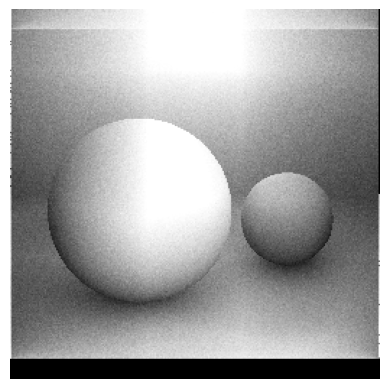

In [10]:
import matplotlib.pyplot as plt

plt.imshow(image, cmap='gray'); plt.axis('off');

## See also

- [<code>mitsuba.Sampler</code>][1]
- [<code>mitsuba.PCG32</code>][2]
- [<code>mitsuba.warp.square_to_uniform_hemisphere()</code>][3]
- [<code>mitsuba.SurfaceInteraction3f.spawn_ray()</code>][4]

[1]: https://mitsuba.readthedocs.io/en/latest/src/api_reference.html#mitsuba.Sampler
[2]: https://mitsuba.readthedocs.io/en/latest/src/api_reference.html#mitsuba.PCG32
[3]: https://mitsuba.readthedocs.io/en/latest/src/api_reference.html#mitsuba.warp.square_to_uniform_hemisphere
[4]: https://mitsuba.readthedocs.io/en/latest/src/api_reference.html#mitsuba.SurfaceInteraction3f.spawn_ray